<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
from bs4 import BeautifulSoup
import requests
df = pd.read_csv("./data/job_listings.csv")
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()



,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [9]:
def clean(x):
    soup = BeautifulSoup(x)
    text = soup.get_text()
    if text[0] == "b":
        text = text[1:]
        text = text.replace("\\n", " ")
    return text
    

In [10]:
df['description'] = df['description'].apply(clean)
df.head()

,description,title
0,"""Job Requirements: Conceptual understanding in...",Data scientist
1,"'Job Description As a Data Scientist 1, you w...",Data Scientist I
2,'As a Data Scientist you will be working on co...,Data Scientist - Entry Level
3,"'$4,969 - $6,756 a monthContractUnder the gene...",Data Scientist
4,'Location: USA \xe2\x80\x93 multiple locations...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [12]:
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [13]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [15]:
tokenize(df['description'][0])

['job',
 'requirement',
 'conceptual',
 'understanding',
 'Machine',
 'Learning',
 'model',
 'like',
 'nai\\xc2\\xa8ve',
 'Bayes',
 'K',
 'Means',
 'SVM',
 'Apriori',
 'Linear/',
 'Logistic',
 'Regression',
 'neural',
 'Random',
 'Forests',
 'decision',
 'Trees',
 'K',
 'NN',
 'hand',
 'experience',
 '2',
 'Intermediate',
 'expert',
 'level',
 'coding',
 'skill',
 'Python',
 'R.',
 'ability',
 'write',
 'function',
 'clean',
 'efficient',
 'datum',
 'manipulation',
 'mandatory',
 'role',
 'exposure',
 'package',
 'like',
 'NumPy',
 'SciPy',
 'Pandas',
 'Matplotlib',
 'etc',
 'Python',
 'GGPlot2',
 'dplyr',
 'tidyR',
 'r',
 'ability',
 'communicate',
 'Model',
 'finding',
 'Technical',
 'Non',
 'technical',
 'stake',
 'holder',
 'hand',
 'experience',
 'SQL',
 'Hive',
 'similar',
 'programming',
 'language',
 'past',
 'work',
 'GitHub',
 'Kaggle',
 'publish',
 'article',
 'Master',
 'degree',
 'Statistics',
 'Mathematics',
 'Computer',
 'Science',
 'quant',
 'specific',
 'field',
 'appl

In [16]:
df['token'] = df['description'].apply(tokenize)

In [17]:
df.head()

,description,title,token
0,"""Job Requirements: Conceptual understanding in...",Data scientist,"[job, requirement, conceptual, understanding, ..."
1,"'Job Description As a Data Scientist 1, you w...",Data Scientist I,"[job, description, , Data, scientist, 1, help,..."
2,'As a Data Scientist you will be working on co...,Data Scientist - Entry Level,"[Data, scientist, work, consult, business, res..."
3,"'$4,969 - $6,756 a monthContractUnder the gene...",Data Scientist,"[$, 4,969, $, 6,756, monthcontractunder, gener..."
4,'Location: USA \xe2\x80\x93 multiple locations...,Data Scientist,"[location, USA, \xe2\x80\x93, multiple, locati..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [18]:

vect = CountVectorizer(tokenizer=tokenize, stop_words='english', max_features=1000)

#Learn our Vocab
vect.fit(df['description'])

# Get sparse dtm
dtm = vect.transform(df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

/home/ekram49/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [19]:
dtm.head()

,,$,+,1,10,100,2,2019,3,4,...,worldwide,write,writing,year,years\xe2\x80\x99,york,you\'ll,you\xe2\x80\x99ll,you\xe2\x80\x99re,||
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5,0,1,2,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [22]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

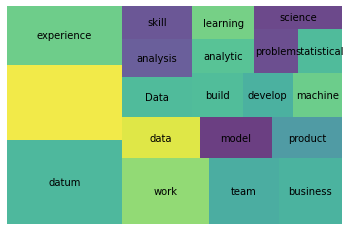

In [23]:
import squarify
wc = count(df['token'])
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(df.description)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,00,000,04,10,100,1000,1079302,11,12,125,...,yes,yeti,york,young,yrs,zenreach,zeus,zf,zillow,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [25]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [26]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.27535065, 1.28667377, 1.29857687, 1.30142574]]),
 array([[  0, 276, 274, 366, 338]]))

In [29]:
df['description'][0][:200]

'"Job Requirements: Conceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along '

In [30]:
df['description'][276][:200]

'"Facebook\'s mission is to give people the power to build community and bring the world closer together. Through our family of apps and services, we\'re building a different kind of company that connect'

In [31]:
job = [ """
           'You are responsible for the collection, cleaning and munging of data to meet the company's purpose. 
           Duties vary according to the industry and may include experimental frameworks for product development 
           and machine learning with the aim to lay a strong data foundation for robust analytics to be performed'
"""]

In [32]:
new = tfidf.transform(job)

In [33]:
nn.kneighbors(new.todense())

(array([[1.31864696, 1.3201421 , 1.32018497, 1.3202686 , 1.3260455 ]]),
 array([[105, 185, 383, 226, 349]]))

In [34]:
df['description'][105][:200]

"'Data Scientist duties will typically be focused on the customer\\xe2\\x80\\x99s business analytics, metrics collection, and analysis efforts to assist the customer\\xe2\\x80\\x99s management team in proces"

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 